# PLM Score vs Population Constraint Curves

This notebook explores the relationship between PLM (protein language model) predicted pathogenicity scores and observed/expected ratios from population data.

**Features:**
- Supports both **RGC** and **gnomAD** data sources
- Supports multiple prediction models: **Core**, **Complete**, **Constraint**
- Generates per-gene curves showing PLM score vs local O/E
- Overlays ClinVar pathogenic variants for validation

**Objectives:**
1. Order missense variants by PLM score (from selected model)
2. Compute sliding window local O/E along this ordering
3. Plot the resulting curve (PLM score on x-axis, local O/E on y-axis)
4. Overlay ClinVar pathogenic/likely pathogenic variants
5. Characterize curve shapes and identify patterns across genes

## Step 1: Initialize Hail and Load Data

In [ ]:
# =============================================================================
# CONFIGURATION - Modify these settings to switch data sources and models
# =============================================================================

# Data source: 'rgc' or 'gnomad'
# - rgc: RGC (Regeneron Genetics Center) variant data
# - gnomad: gnomAD v4 variant data
DATA_SOURCE = 'rgc'

# Prediction model: 'constraint', 'core', or 'complete'
# - constraint: Constraint-aware model (uses population constraint features)
# - core: Core features only (sequence-based, no structural features)
# - complete: Complete feature set (includes structural/AlphaFold features)
PREDICTION_MODEL = 'constraint'

# =============================================================================
# Path configuration - Update these paths for your environment
# =============================================================================
import yaml
import os

# Try to load from config file, fall back to defaults
config_path = '../config/paths.yaml'
if os.path.exists(config_path):
    with open(config_path, 'r') as f:
        config = yaml.safe_load(f)
    DATA_PATHS = config['data_sources']
    HAIL_CONFIG = config.get('hail', {})
else:
    # Default paths (update for your environment)
    DATA_PATHS = {
        'rgc_scaled': '/storage/zoghbi/home/u235147/merged_vars/rgc_scaled.ht',
        'gnomad_scaled': '/storage/zoghbi/home/u235147/merged_vars/gnomadV4_scaled.ht',
        'predictions': '/local/Missense_Predictor_copy/Results/Inference/Predictions/AOU_RGC_All_preds.ht',
        'clinvar': '/storage/zoghbi/data/sharing/hail_tables/cv_38_final.ht',
    }
    HAIL_CONFIG = {'cpus': 40, 'tmpdir': '/local/tmp'}

# Prediction model column mapping
PREDICTION_MODELS = {
    'constraint': 'Constraint_1000_General_aou_observed_neg4_pred',
    'core': 'Core_1000_General_aou_observed_neg4_pred',
    'complete': 'Complete_1000_General_aou_observed_neg4_pred'
}

# Validate configuration
assert DATA_SOURCE in ['rgc', 'gnomad'], f"Invalid DATA_SOURCE: {DATA_SOURCE}"
assert PREDICTION_MODEL in PREDICTION_MODELS, f"Invalid PREDICTION_MODEL: {PREDICTION_MODEL}"

print(f"Configuration:")
print(f"  Data Source: {DATA_SOURCE}")
print(f"  Prediction Model: {PREDICTION_MODEL}")
print(f"  PLM Score Column: {PREDICTION_MODELS[PREDICTION_MODEL]}")

In [ ]:
import hail as hl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')

# Hail configuration from config file or defaults
cpus = HAIL_CONFIG.get('cpus', 40)
tmpdir = HAIL_CONFIG.get('tmpdir', '/local/tmp')
memory = int(3600 * cpus / 256)

spark_config = {
    'spark.driver.memory': f'{memory}g',
    'spark.executor.memory': f'{memory}g',
    'spark.local.dir': tmpdir,
    'spark.ui.enabled': 'false'
}

hl.init(spark_conf=spark_config, master=f'local[{cpus}]', tmp_dir=tmpdir, local_tmpdir=tmpdir)

%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')

# Set paths based on DATA_SOURCE configuration
if DATA_SOURCE == 'rgc':
    main_ht_path = DATA_PATHS['rgc_scaled']
elif DATA_SOURCE == 'gnomad':
    main_ht_path = DATA_PATHS['gnomad_scaled']
    
plm_ht_path = DATA_PATHS['predictions']
clinvar_path = DATA_PATHS['clinvar']

# Output directory - include data source and model in name
output_dir = f'../output/curve_data/{DATA_SOURCE}_{PREDICTION_MODEL}'

print(f"\nPaths configured:")
print(f"  Main variant table: {main_ht_path}")
print(f"  Predictions table: {plm_ht_path}")
print(f"  ClinVar table: {clinvar_path}")
print(f"  Output directory: {output_dir}")

In [ ]:
# Create output directory
import os
os.makedirs(output_dir, exist_ok=True)
os.makedirs(f'{output_dir}/gene_plots', exist_ok=True)

In [ ]:
# Load PLM predictions and check structure
plm_ht = hl.read_table(plm_ht_path)
print("PLM predictions structure:")
plm_ht.describe()

In [ ]:
# Load main variant table
main_ht = hl.read_table(main_ht_path)
print("Main variant table structure:")
main_ht.describe()

## Step 2: Join Tables and Filter to Missense Variants

In [ ]:
# Join PLM scores to main table
# The PLM table has locus and alleles but is not keyed by default
print("PLM table fields:", [f for f in plm_ht.row])
print("Main table key:", main_ht.key)

# Key PLM table by locus and alleles for joining
plm_ht = plm_ht.key_by('locus', 'alleles')
print("PLM table now keyed by:", plm_ht.key)

# Get the PLM score column name from configuration
plm_score_col = PREDICTION_MODELS[PREDICTION_MODEL]
print(f"\nUsing prediction model: {PREDICTION_MODEL}")
print(f"PLM score column: {plm_score_col}")

# Join PLM scores - using the configured prediction model
main_ht = main_ht.annotate(
    plm_score = plm_ht[main_ht.locus, main_ht.alleles][plm_score_col]
)

# Filter to missense variants with valid data
# Note: Both RGC and gnomAD tables use the same column names for XX_XY exomes
missense_ht = main_ht.filter(
    (main_ht.most_deleterious_consequence_cds == 'missense_variant') &
    hl.is_defined(main_ht.plm_score) &
    hl.is_defined(main_ht.roulette_AR_MR_scaled_exomes_XX_XY) &
    (main_ht.roulette_AR_MR_scaled_exomes_XX_XY > 0)
)

# Extract transcript ID from region
missense_ht = missense_ht.annotate(
    transcript = missense_ht.region.split('-')[0]
)

# Checkpoint for efficiency
missense_ht = missense_ht.checkpoint(f'{tmpdir}/eda_step1_missense_{DATA_SOURCE}_{PREDICTION_MODEL}.ht', overwrite=True)
print(f"\nFiltered missense variants with PLM scores: {missense_ht.count():,}")
print(f"Data source: {DATA_SOURCE}, Prediction model: {PREDICTION_MODEL}")

## Step 3: Extract ClinVar Pathogenic Variants

In [ ]:
def get_valid_origin_sums():
    """Calculate all valid origin code sums (excluding somatic-only=2)."""
    origin_codes = [0, 1, 2, 4, 8, 16, 32, 256]
    all_sums = set()
    for r in range(1, len(origin_codes) + 1):
        for combo in combinations(origin_codes, r):
            all_sums.add(sum(combo))
    return sorted([s for s in all_sums if s != 2])

def extract_pathogenic_variants(clinvar_path):
    """
    Extract filtered pathogenic missense variants from ClinVar.
    
    Note: ClinVar fields are nested under 'clinvar_38' struct.
    MC field contains molecular consequence - we filter to missense_variant.
    """
    clinvar = hl.read_table(clinvar_path)
    
    # Check structure
    print("ClinVar table structure:")
    clinvar.describe()
    
    valid_origins = get_valid_origin_sums()
    valid_origins_set = hl.set([str(i) for i in valid_origins])
    
    # Access nested fields under clinvar_38
    cv = clinvar.clinvar_38

    # Filter 1: Pathogenic missense variants
    # MC is an array of molecular consequences
    path_ht = clinvar.filter(
        hl.any(lambda mc: mc.contains('missense_variant'), cv.MC) &
        hl.any(lambda sig: sig.matches("athogenic"), cv.CLNSIG)  # matches Pathogenic or Likely_pathogenic
    )
    print(f"After pathogenic missense filter: {path_ht.count()}")

    # Filter 2: Valid germline origin (exclude somatic-only)
    path_ht = path_ht.filter(
        hl.any(lambda origin: valid_origins_set.contains(origin), path_ht.clinvar_38.ORIGIN)
    )
    print(f"After origin filter: {path_ht.count()}")

    # Filter 3: Exclude conflicting interpretations
    path_ht = path_ht.filter(
        ~hl.any(lambda sig: sig.contains("Conflicting"), path_ht.clinvar_38.CLNSIG)
    )
    print(f"After excluding conflicting: {path_ht.count()}")

    return path_ht

# Extract ClinVar pathogenic variants
clinvar_ht = extract_pathogenic_variants(clinvar_path)
# Table is already keyed by locus, alleles based on the schema
print(f"ClinVar table key: {clinvar_ht.key}")

In [ ]:
# Annotate missense variants with ClinVar status
# ClinVar table is already keyed by locus, alleles
missense_ht = missense_ht.annotate(
    is_clinvar_pathogenic = hl.is_defined(clinvar_ht[missense_ht.locus, missense_ht.alleles])
)

missense_ht = missense_ht.checkpoint(f'{tmpdir}/eda_step2_with_clinvar.ht', overwrite=True)

n_clinvar = missense_ht.aggregate(hl.agg.count_where(missense_ht.is_clinvar_pathogenic))
print(f"ClinVar P/LP missense variants in dataset: {n_clinvar:,}")

## Step 4: Compute Gene-Level Constraint

In [ ]:
# Calculate gene-level O/E
gene_constraint = missense_ht.group_by('transcript').aggregate(
    total_obs=hl.agg.sum(missense_ht.binary_presence_exomes_XX_XY),
    total_exp=hl.agg.sum(missense_ht.roulette_AR_MR_scaled_exomes_XX_XY),
    n_variants=hl.agg.count(),
    n_clinvar_pathogenic=hl.agg.count_where(missense_ht.is_clinvar_pathogenic),
    mean_plm=hl.agg.mean(missense_ht.plm_score),
    median_plm=hl.agg.approx_quantiles(missense_ht.plm_score, [0.5])[0]
)

gene_constraint = gene_constraint.annotate(
    gene_oe=gene_constraint.total_obs / gene_constraint.total_exp
)

# Compute quintiles based on gene O/E
gene_constraint = gene_constraint.order_by('gene_oe')
gene_constraint = gene_constraint.add_index('rank')
n_genes = gene_constraint.count()
gene_constraint = gene_constraint.annotate(
    constraint_quintile=hl.int32((gene_constraint.rank * 5) / n_genes) + 1
)

gene_constraint = gene_constraint.checkpoint(f'{tmpdir}/eda_gene_constraint.ht', overwrite=True)
print(f"Computed constraint for {n_genes:,} genes")

In [ ]:
# Show distribution of gene O/E
gene_df = gene_constraint.to_pandas()

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# O/E distribution
axes[0].hist(gene_df['gene_oe'].clip(0, 2), bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(x=1, color='red', linestyle='--', label='O/E = 1')
axes[0].set_xlabel('Gene O/E (clipped at 2)')
axes[0].set_ylabel('Count')
axes[0].set_title('Distribution of Gene-Level O/E')
axes[0].legend()

# Variant count distribution
axes[1].hist(np.log10(gene_df['n_variants'] + 1), bins=50, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('log10(n_variants + 1)')
axes[1].set_ylabel('Count')
axes[1].set_title('Distribution of Variant Counts per Gene')

# O/E vs variant count
axes[2].scatter(gene_df['n_variants'], gene_df['gene_oe'].clip(0, 2), alpha=0.3, s=5)
axes[2].axhline(y=1, color='red', linestyle='--', alpha=0.7)
axes[2].set_xlabel('n_variants')
axes[2].set_ylabel('Gene O/E (clipped at 2)')
axes[2].set_title('O/E vs Variant Count')
axes[2].set_xscale('log')

plt.tight_layout()
plt.savefig(f'{output_dir}/gene_constraint_summary.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nGene O/E summary:")
print(gene_df['gene_oe'].describe())

## Step 5: Compute Sliding Window O/E by PLM Score (Pure Hail)

For each gene, order variants by PLM score and compute local O/E using symmetric window expansion until expected count >= threshold. This is done entirely in Hail using scan operations, avoiding pandas export.

In [ ]:
# Configuration
MAX_WINDOW = 150  # Neighbors on each side (total max = 300)
MIN_EXPECTED = 10.0  # Minimum expected count for window

# Step 5a: Order by transcript + PLM score and add index
print("Ordering by transcript and PLM score...")
missense_ht = missense_ht.order_by('transcript', 'plm_score')

# Add global index and detect transcript boundaries
missense_ht = missense_ht.annotate(
    __idx=hl.scan.count(),
    __prev_transcript=hl.scan.fold(
        hl.missing(hl.tstr),
        lambda acc: missense_ht.transcript,
        lambda a, b: b
    )
)

# Detect transcript change
missense_ht = missense_ht.annotate(
    __transcript_match=hl.if_else(
        (missense_ht.__prev_transcript == missense_ht.transcript) | hl.is_missing(missense_ht.__prev_transcript),
        1, 0
    )
)

# Position within transcript (resets on transcript change)  
missense_ht = missense_ht.annotate(
    __transcript_pos=hl.rbind(
        hl.scan.fold(
            1,
            lambda acc: hl.if_else(missense_ht.__transcript_match == 0, 2, acc + 1),
            lambda a, b: b
        ),
        lambda acc: hl.if_else(missense_ht.__transcript_match == 0, 1, acc)
    )
)

missense_ht = missense_ht.checkpoint(f'{tmpdir}/eda_step5a_ordered.ht', overwrite=True)
print(f"Ordered {missense_ht.count():,} variants by transcript and PLM score")

In [ ]:
# Step 5b: Build neighbor arrays using scan (like add_oe_windows in constraint_utils.py)
print("Building neighbor arrays...")

# Struct type for neighbor info
neighbor_struct = hl.tstruct(obs=hl.tint32, exp=hl.tfloat64)

# Create empty array of correct type
empty_neighbors = hl.empty_array(neighbor_struct)

# Forward pass (descending index): collect "following" neighbors (higher PLM scores)
missense_ht = missense_ht.order_by(hl.desc(missense_ht.__idx))

missense_ht = missense_ht.annotate(
    __following=hl.scan.fold(
        empty_neighbors,
        lambda acc: hl.if_else(
            missense_ht.__transcript_match == 0,
            empty_neighbors,  # Reset on new transcript
            hl.array([hl.struct(
                obs=missense_ht.binary_presence_exomes_XX_XY,
                exp=missense_ht.roulette_AR_MR_scaled_exomes_XX_XY
            )]).extend(acc)[:MAX_WINDOW]
        ),
        lambda a, b: b
    )
)

missense_ht = missense_ht.checkpoint(f'{tmpdir}/eda_step5b_following.ht', overwrite=True)
print("Built following neighbor arrays")

In [ ]:
# Step 5c: Backward pass - collect "previous" neighbors (lower PLM scores)
missense_ht = missense_ht.order_by(hl.asc(missense_ht.__idx))

missense_ht = missense_ht.annotate(
    __previous=hl.scan.fold(
        empty_neighbors,
        lambda acc: hl.if_else(
            missense_ht.__transcript_match == 0,
            empty_neighbors,  # Reset on new transcript
            hl.array([hl.struct(
                obs=missense_ht.binary_presence_exomes_XX_XY,
                exp=missense_ht.roulette_AR_MR_scaled_exomes_XX_XY
            )]).extend(acc)[:MAX_WINDOW]
        ),
        lambda a, b: b
    )
)

missense_ht = missense_ht.checkpoint(f'{tmpdir}/eda_step5c_previous.ht', overwrite=True)
print("Built previous neighbor arrays")

In [ ]:
# Step 5d: Compute local O/E with symmetric window expansion
# Adapted from calculate_oe in constraint_utils.py
print("Computing local O/E with symmetric window expansion...")

# Get transcript sizes
transcript_sizes = missense_ht.group_by('transcript').aggregate(
    __transcript_size=hl.agg.count()
)
missense_ht = missense_ht.annotate(
    __transcript_size=transcript_sizes[missense_ht.transcript].__transcript_size
)

# Compute local O/E using neighbor arrays
# The window expands symmetrically; at edges, take more from available side
missense_ht = missense_ht.annotate(
    # Available neighbors on each side
    __avail_prev=hl.len(missense_ht.__previous),
    __avail_foll=hl.len(missense_ht.__following),
    
    # Current variant's values
    __current_obs=missense_ht.binary_presence_exomes_XX_XY,
    __current_exp=missense_ht.roulette_AR_MR_scaled_exomes_XX_XY
)

# Combine all values: previous + current + following
# Note: __previous is in reverse order (most recent first), so reverse it
missense_ht = missense_ht.annotate(
    __all_values=missense_ht.__previous[::-1].extend(
        hl.array([hl.struct(
            obs=missense_ht.__current_obs,
            exp=missense_ht.__current_exp
        )])
    ).extend(missense_ht.__following)
)

# Compute window O/E
# For now, use all available neighbors (up to MAX_WINDOW on each side)
# The sliding window inherently smooths the curve
missense_ht = missense_ht.annotate(
    window_obs=hl.sum(missense_ht.__all_values.map(lambda x: x.obs)),
    window_exp=hl.sum(missense_ht.__all_values.map(lambda x: x.exp)),
    window_size=hl.len(missense_ht.__all_values)
)

missense_ht = missense_ht.annotate(
    local_oe=hl.if_else(
        missense_ht.window_exp >= MIN_EXPECTED,
        missense_ht.window_obs / missense_ht.window_exp,
        hl.missing(hl.tfloat64)  # Not enough expected for reliable O/E
    )
)

# Clean up intermediate fields
missense_ht = missense_ht.drop(
    '__previous', '__following', '__all_values',
    '__avail_prev', '__avail_foll', '__current_obs', '__current_exp'
)

missense_ht = missense_ht.checkpoint(f'{tmpdir}/eda_step5d_local_oe.ht', overwrite=True)

# Summary
n_with_oe = missense_ht.aggregate(hl.agg.count_where(hl.is_defined(missense_ht.local_oe)))
print(f"Computed local O/E for {n_with_oe:,} variants")

## Step 6: Characterize Curve Shapes

In [ ]:
# Step 6a: Compute gene-level statistics in Hail
print("Computing gene-level statistics...")

gene_stats = missense_ht.group_by('transcript').aggregate(
    n_variants=hl.agg.count(),
    n_with_oe=hl.agg.count_where(hl.is_defined(missense_ht.local_oe)),
    total_obs=hl.agg.sum(missense_ht.binary_presence_exomes_XX_XY),
    total_exp=hl.agg.sum(missense_ht.roulette_AR_MR_scaled_exomes_XX_XY),
    
    # PLM score statistics
    mean_plm=hl.agg.mean(missense_ht.plm_score),
    min_plm=hl.agg.min(missense_ht.plm_score),
    max_plm=hl.agg.max(missense_ht.plm_score),
    
    # Local O/E statistics
    mean_local_oe=hl.agg.mean(missense_ht.local_oe),
    min_local_oe=hl.agg.min(missense_ht.local_oe),
    max_local_oe=hl.agg.max(missense_ht.local_oe),
    
    # Correlation between PLM and local O/E (key metric!)
    plm_oe_corr=hl.agg.corr(missense_ht.plm_score, missense_ht.local_oe),
    
    # ClinVar counts
    n_clinvar=hl.agg.count_where(missense_ht.is_clinvar_pathogenic),
    
    # Mean O/E at ClinVar sites
    clinvar_mean_oe=hl.agg.filter(
        missense_ht.is_clinvar_pathogenic,
        hl.agg.mean(missense_ht.local_oe)
    )
)

# Add derived metrics
gene_stats = gene_stats.annotate(
    gene_oe=gene_stats.total_obs / gene_stats.total_exp,
    oe_range=gene_stats.max_local_oe - gene_stats.min_local_oe
)

gene_stats = gene_stats.checkpoint(f'{tmpdir}/eda_gene_stats.ht', overwrite=True)
print(f"Computed statistics for {gene_stats.count():,} genes")

In [ ]:
# Step 6b: Classify genes by curve shape and add constraint quintiles
print("Classifying gene curves...")

# Add curve classification
gene_stats = gene_stats.annotate(
    # Monotonically decreasing: strong negative correlation
    is_monotonic=gene_stats.plm_oe_corr < -0.5,
    
    # Flat: O/E range < 0.2
    is_flat=gene_stats.oe_range < 0.2,
    
    # Curve category
    curve_category=hl.case()
        .when(gene_stats.oe_range < 0.2, 'flat')
        .when(gene_stats.plm_oe_corr < -0.5, 'monotonic_decreasing')
        .when(gene_stats.plm_oe_corr > 0.3, 'monotonic_increasing')
        .default('other')
)

# Add constraint quintiles
gene_stats = gene_stats.order_by('gene_oe')
gene_stats = gene_stats.add_index('rank')
n_genes = gene_stats.count()
gene_stats = gene_stats.annotate(
    constraint_quintile=hl.int32((gene_stats.rank * 5) / n_genes) + 1
)

gene_stats = gene_stats.checkpoint(f'{tmpdir}/eda_gene_stats_classified.ht', overwrite=True)

# Show category distribution
category_counts = gene_stats.group_by('curve_category').aggregate(n=hl.agg.count())
print("\n=== Curve Category Summary ===")
category_counts.show()

In [ ]:
# Step 6c: Export to Polars for visualization
import polars as pl

print("Exporting data for visualization...")

# Export gene stats
gene_stats.export(f'{output_dir}/gene_stats.tsv')

# Export curve data (variant-level) to parquet for polars
curve_data = missense_ht.select(
    'transcript',
    'plm_score',
    'local_oe',
    'is_clinvar_pathogenic',
    'binary_presence_exomes_XX_XY',
    'roulette_AR_MR_scaled_exomes_XX_XY',
    'window_size',
    'window_obs',
    'window_exp',
    '__transcript_pos'
)

# Export to parquet
curve_data.to_spark().write.mode('overwrite').parquet(f'{output_dir}/curve_data.parquet')
print(f"Saved curve data to {output_dir}/curve_data.parquet")

# Read with polars - use glob pattern to read only .parquet files (Spark writes directory with part files)
curve_df = pl.read_parquet(f'{output_dir}/curve_data.parquet/**/*.parquet')
print(f"Loaded {curve_df.height:,} variants into polars")
print(f"Columns: {curve_df.columns}")

In [3]:
import polars as pl
curve_df = pl.read_parquet(f'{output_dir}/curve_data.parquet/**/*.parquet')
print(f"Loaded {curve_df.height:,} variants into polars")
print(f"Columns: {curve_df.columns}")

Loaded 72,174,760 variants into polars
Columns: ['transcript', 'plm_score', 'local_oe', 'is_clinvar_pathogenic', 'binary_presence_exomes_XX_XY', 'roulette_AR_MR_scaled_exomes_XX_XY', 'window_size', 'window_obs', 'window_exp', '__transcript_pos']


<cell_type>markdown</cell_type>## Step 7: Load Gene Stats and Visualize Curve Characteristics

In [4]:
# Load gene stats into polars
stats_df = pl.read_csv(f'{output_dir}/gene_stats.tsv', separator='\t')
print(f"Loaded stats for {stats_df.height:,} genes")
print(f"Columns: {stats_df.columns}")

# Show category distribution
print("\n=== Curve Category Summary ===")
category_counts = stats_df.group_by('curve_category').agg(pl.count().alias('count'))
category_counts = category_counts.with_columns(
    (pl.col('count') * 100 / stats_df.height).alias('percentage')
)
print(category_counts)

Loaded stats for 19,133 genes
Columns: ['transcript', 'n_variants', 'n_with_oe', 'total_obs', 'total_exp', 'mean_plm', 'min_plm', 'max_plm', 'mean_local_oe', 'min_local_oe', 'max_local_oe', 'plm_oe_corr', 'n_clinvar', 'clinvar_mean_oe', 'gene_oe', 'oe_range', 'is_monotonic', 'is_flat', 'curve_category', 'rank', 'constraint_quintile']

=== Curve Category Summary ===
shape: (3, 3)
┌──────────────────────┬───────┬────────────┐
│ curve_category       ┆ count ┆ percentage │
│ ---                  ┆ ---   ┆ ---        │
│ str                  ┆ u32   ┆ f64        │
╞══════════════════════╪═══════╪════════════╡
│ monotonic_decreasing ┆ 18341 ┆ 95.860555  │
│ flat                 ┆ 662   ┆ 3.459991   │
│ other                ┆ 130   ┆ 0.679454   │
└──────────────────────┴───────┴────────────┘


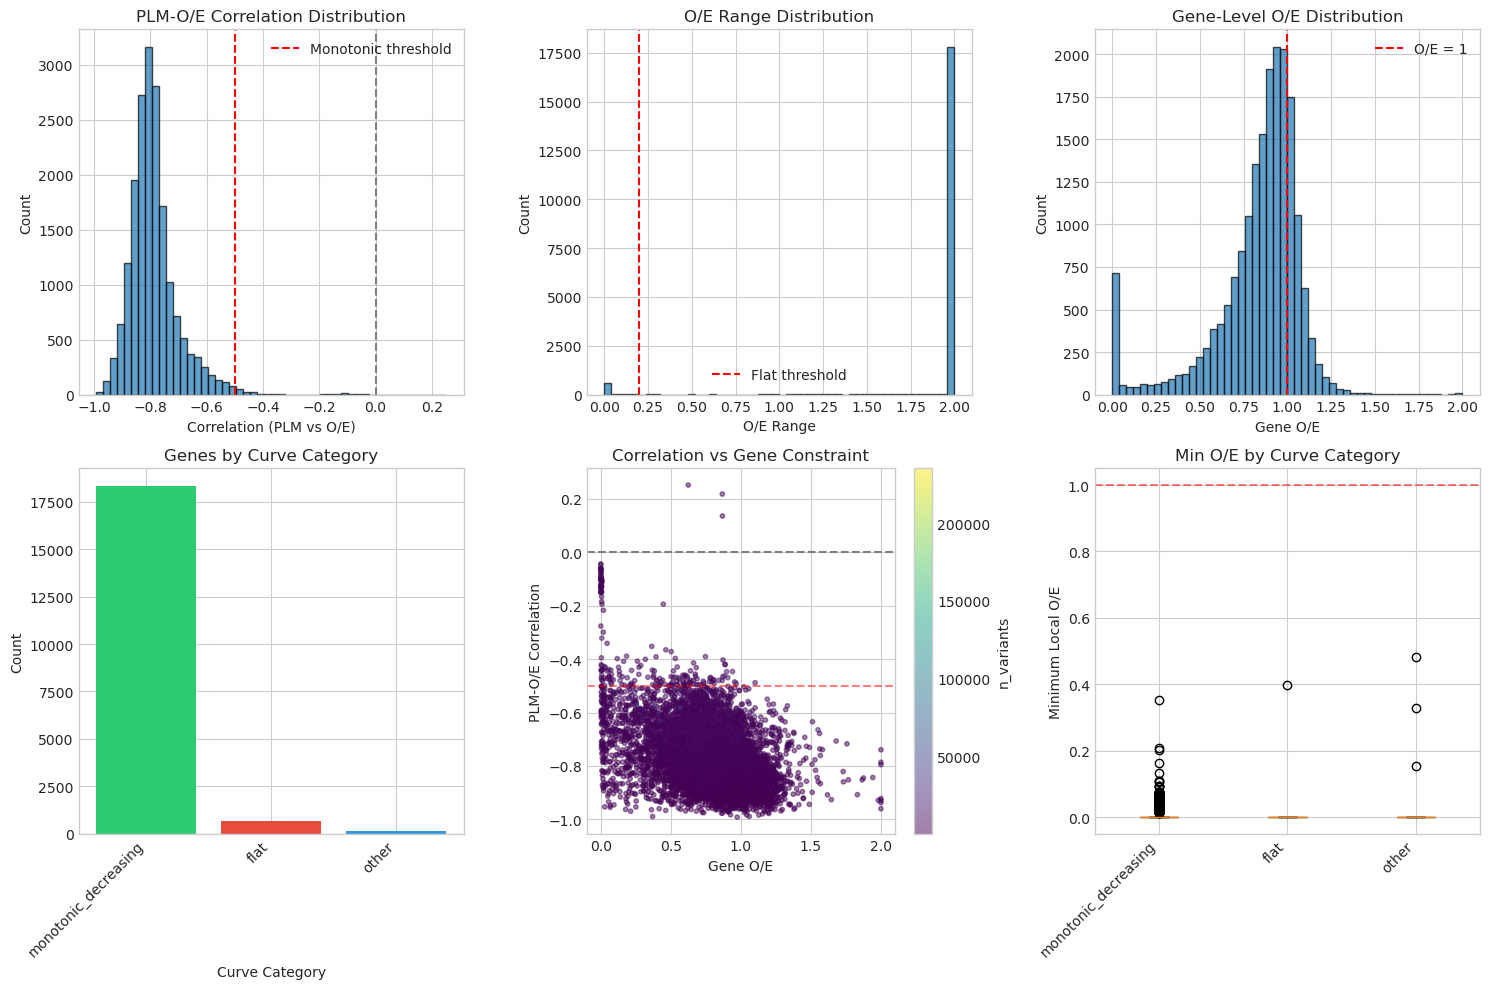

In [5]:
# Visualize distribution of curve characteristics
# Convert to pandas for matplotlib compatibility
stats_pd = stats_df.to_pandas()

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# PLM-O/E correlation distribution
axes[0, 0].hist(stats_pd['plm_oe_corr'].dropna(), bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].axvline(x=0, color='gray', linestyle='--')
axes[0, 0].axvline(x=-0.5, color='red', linestyle='--', label='Monotonic threshold')
axes[0, 0].set_xlabel('Correlation (PLM vs O/E)')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_title('PLM-O/E Correlation Distribution')
axes[0, 0].legend()

# O/E range distribution
axes[0, 1].hist(stats_pd['oe_range'].dropna().clip(0, 2), bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].axvline(x=0.2, color='red', linestyle='--', label='Flat threshold')
axes[0, 1].set_xlabel('O/E Range')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_title('O/E Range Distribution')
axes[0, 1].legend()

# Gene O/E distribution
axes[0, 2].hist(stats_pd['gene_oe'].clip(0, 2), bins=50, edgecolor='black', alpha=0.7)
axes[0, 2].axvline(x=1, color='red', linestyle='--', label='O/E = 1')
axes[0, 2].set_xlabel('Gene O/E')
axes[0, 2].set_ylabel('Count')
axes[0, 2].set_title('Gene-Level O/E Distribution')
axes[0, 2].legend()

# Category counts
category_counts_pd = stats_pd['curve_category'].value_counts()
colors = ['#2ecc71', '#e74c3c', '#3498db', '#9b59b6', '#95a5a6']
axes[1, 0].bar(category_counts_pd.index, category_counts_pd.values, color=colors[:len(category_counts_pd)])
axes[1, 0].set_xlabel('Curve Category')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title('Genes by Curve Category')
plt.setp(axes[1, 0].xaxis.get_majorticklabels(), rotation=45, ha='right')

# Correlation vs Gene O/E
scatter = axes[1, 1].scatter(stats_pd['gene_oe'].clip(0, 2), stats_pd['plm_oe_corr'], 
                             c=stats_pd['n_variants'], cmap='viridis', alpha=0.5, s=10)
axes[1, 1].axhline(y=0, color='gray', linestyle='--')
axes[1, 1].axhline(y=-0.5, color='red', linestyle='--', alpha=0.5)
axes[1, 1].set_xlabel('Gene O/E')
axes[1, 1].set_ylabel('PLM-O/E Correlation')
axes[1, 1].set_title('Correlation vs Gene Constraint')
plt.colorbar(scatter, ax=axes[1, 1], label='n_variants')

# Min O/E by category
cats = ['monotonic_decreasing', 'monotonic_increasing', 'flat', 'other']
box_data = [stats_pd[stats_pd['curve_category'] == cat]['min_local_oe'].dropna() for cat in cats if cat in stats_pd['curve_category'].values]
box_labels = [cat for cat in cats if cat in stats_pd['curve_category'].values]
if box_data:
    bp = axes[1, 2].boxplot(box_data, labels=box_labels, patch_artist=True)
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
axes[1, 2].axhline(y=1, color='red', linestyle='--', alpha=0.5)
axes[1, 2].set_ylabel('Minimum Local O/E')
axes[1, 2].set_title('Min O/E by Curve Category')
plt.setp(axes[1, 2].xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig(f'{output_dir}/curve_characteristics.png', dpi=150, bbox_inches='tight')
plt.show()

<cell_type>markdown</cell_type>## Step 8: Generate Example Gene Plots

In [6]:
def plot_gene_curve(transcript, curve_df_pl, gene_stats_row, ax=None, show_title=True):
    """
    Plot the PLM vs O/E curve for a gene using polars dataframe.
    
    Args:
        transcript: Gene transcript ID
        curve_df_pl: Polars dataframe with curve data
        gene_stats_row: Row from gene stats dataframe (dict or pandas Series)
        ax: Matplotlib axis
        show_title: Whether to show title
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 5))
    
    # Filter to this transcript
    gene_data = curve_df_pl.filter(pl.col('transcript') == transcript)
    
    # Get valid data (where local_oe is not null)
    valid_data = gene_data.filter(pl.col('local_oe').is_not_null())
    
    if valid_data.height < 2:
        ax.text(0.5, 0.5, 'Insufficient data', ha='center', va='center', transform=ax.transAxes)
        return ax
    
    # Sort by PLM score for plotting
    valid_data = valid_data.sort('plm_score')
    plm = valid_data['plm_score'].to_numpy()
    oe = valid_data['local_oe'].to_numpy()
    
    # Plot the curve
    ax.plot(plm, oe, 'b-', alpha=0.7, linewidth=1.5)
    
    # Reference line at O/E = 1
    ax.axhline(y=1.0, color='gray', linestyle='--', alpha=0.5, label='O/E = 1')
    
    # ClinVar pathogenic variants
    clinvar_data = gene_data.filter(pl.col('is_clinvar_pathogenic') == True)
    if clinvar_data.height > 0:
        clinvar_plm = clinvar_data['plm_score'].to_numpy()
        for plm_val in clinvar_plm:
            ax.axvline(x=plm_val, color='red', alpha=0.3, linewidth=1)
        # Add legend entry
        ax.axvline(x=np.nan, color='red', alpha=0.5, linewidth=2, label='ClinVar P/LP')
    
    ax.set_xlabel('PLM Score')
    ax.set_ylabel('Local O/E')
    
    if show_title:
        gene_oe = gene_stats_row.get('gene_oe', np.nan)
        n_variants = gene_stats_row.get('n_variants', gene_data.height)
        n_clinvar = clinvar_data.height
        ax.set_title(f'{transcript}\n(gene O/E = {gene_oe:.2f}, n = {n_variants}, n_clinvar = {n_clinvar})')
    
    ax.legend(loc='upper right')
    ax.set_ylim(0, max(2.5, np.nanmax(oe) * 1.1))
    
    return ax

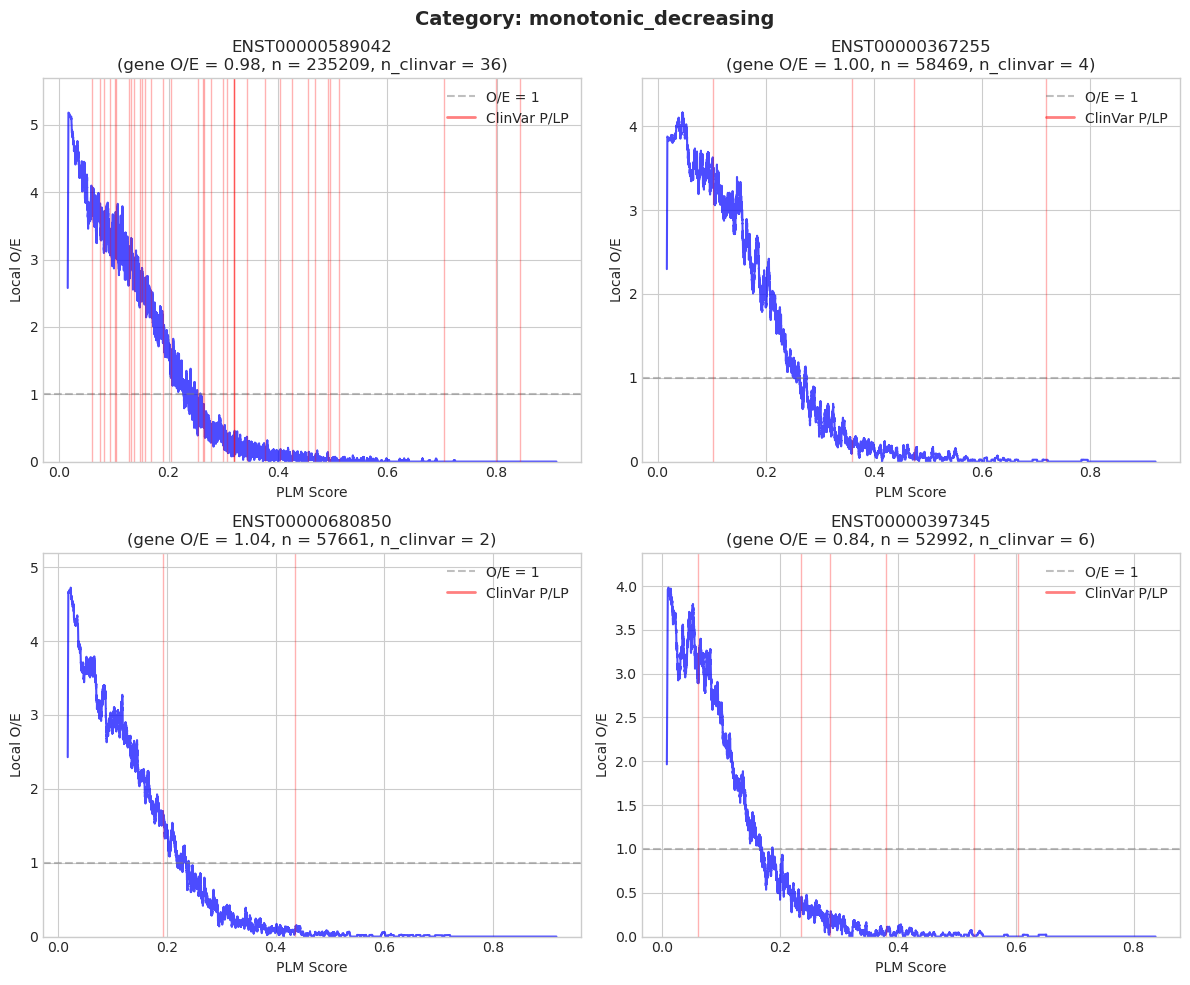

No genes in category: monotonic_increasing


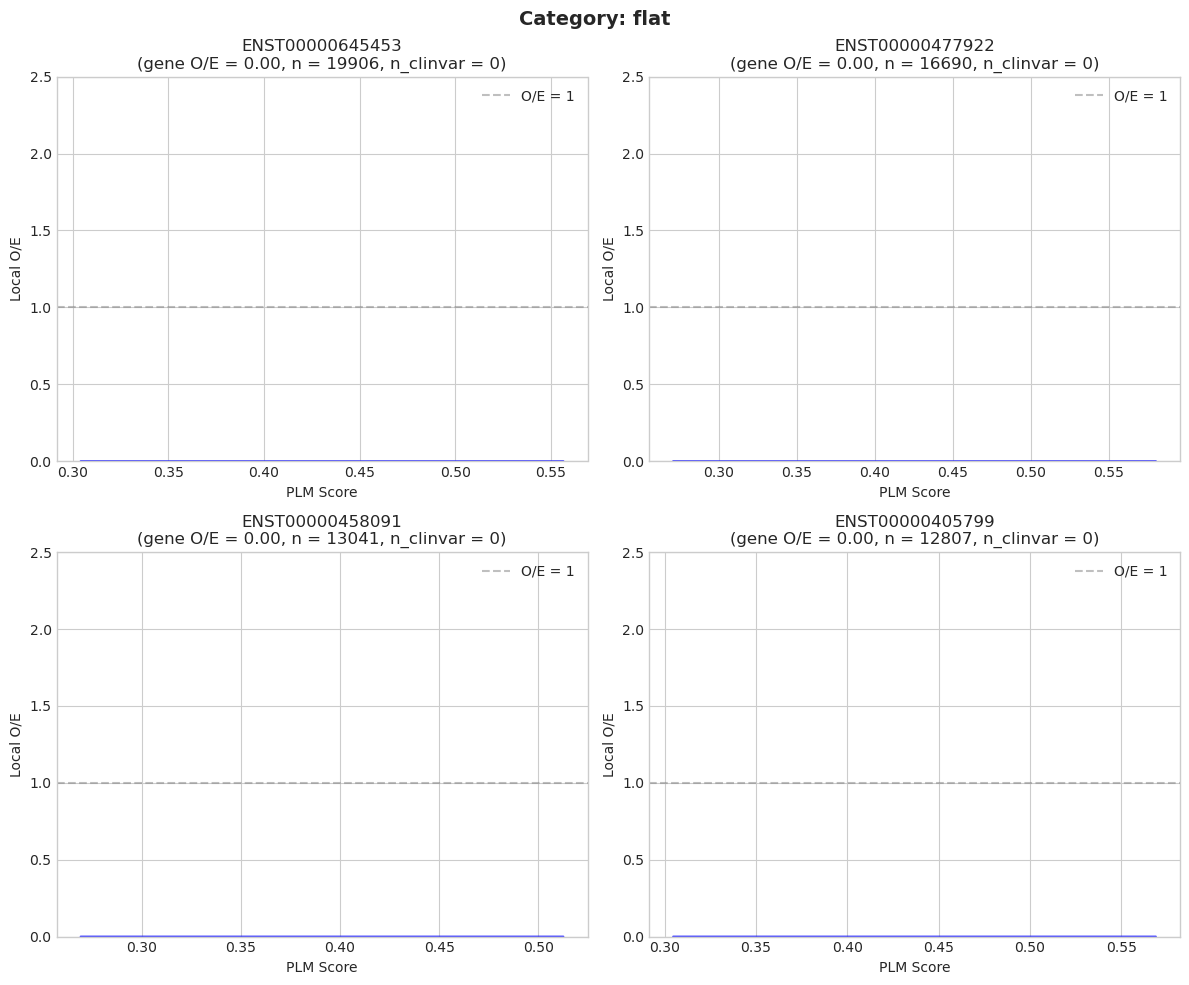

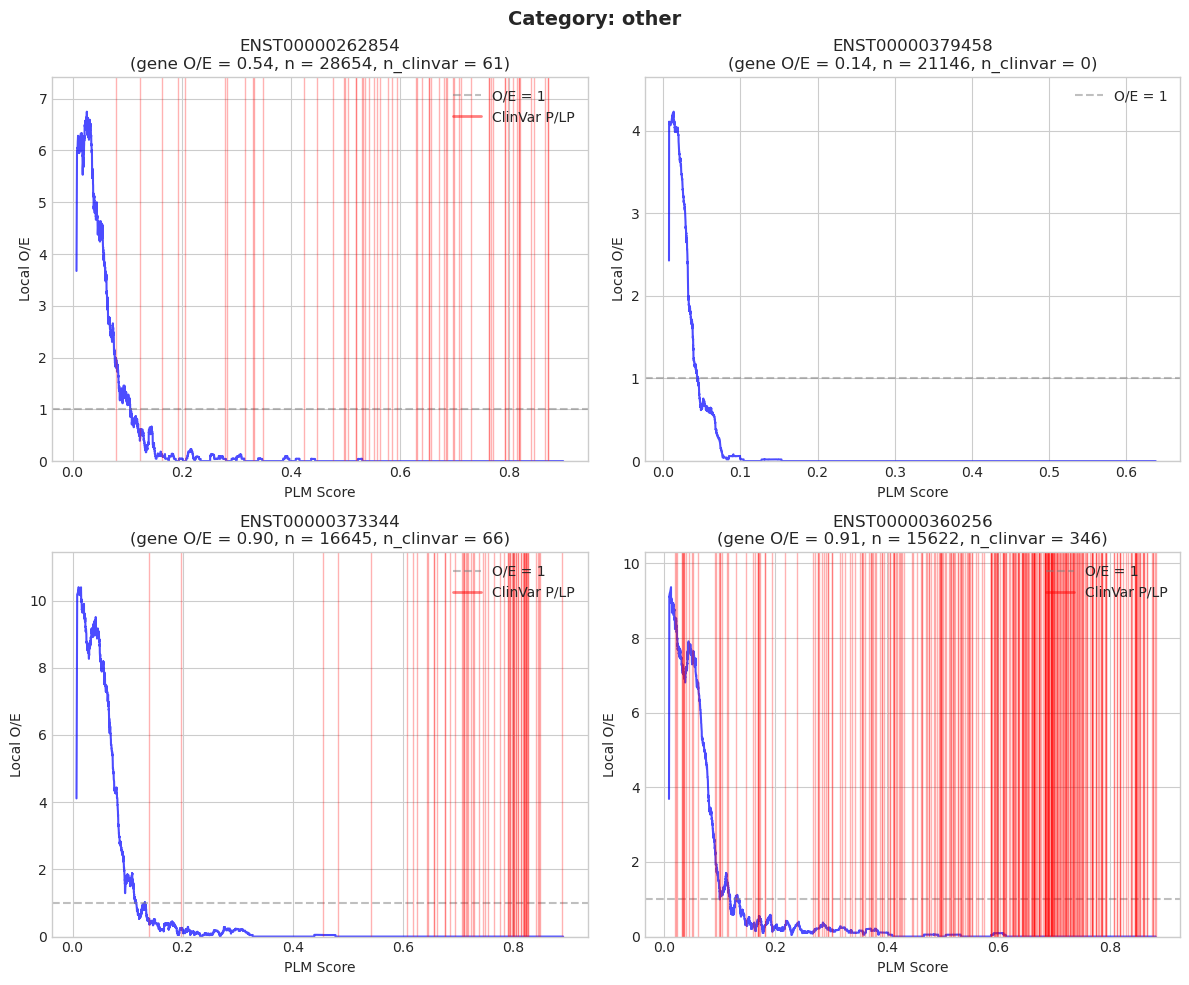

In [7]:
# Plot examples from each category
categories_to_plot = ['monotonic_decreasing', 'monotonic_increasing', 'flat', 'other']
n_examples = 4

# Create stats lookup dictionary
stats_lookup = {row['transcript']: row for row in stats_pd.to_dict(orient='records')}

for category in categories_to_plot:
    # Get genes in this category, sorted by variant count
    cat_genes = stats_df.filter(pl.col('curve_category') == category).sort('n_variants', descending=True)
    
    if cat_genes.height == 0:
        print(f"No genes in category: {category}")
        continue
    
    transcripts = cat_genes['transcript'].head(n_examples * 2).to_list()
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()
    
    plotted = 0
    for transcript in transcripts:
        if plotted >= n_examples:
            break
        
        # Check if transcript has data
        gene_data = curve_df.filter(pl.col('transcript') == transcript)
        if gene_data.height < 10:
            continue
        
        gene_stats_row = stats_lookup.get(transcript, {})
        plot_gene_curve(transcript, curve_df, gene_stats_row, ax=axes[plotted])
        plotted += 1
    
    # Hide unused axes
    for i in range(plotted, len(axes)):
        axes[i].set_visible(False)
    
    fig.suptitle(f'Category: {category}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'{output_dir}/examples_{category}.png', dpi=150, bbox_inches='tight')
    plt.show()

## Step 9: Category Overlay Plots

In [8]:
def plot_category_overlay(category_name, transcripts, curve_df_pl, max_genes=50):
    """
    Overlay curves from multiple genes in the same category.
    Normalize PLM scores to [0,1] for comparability.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Left plot: Normalized PLM
    ax1 = axes[0]
    interpolated = []
    n_points = 100
    x_grid = np.linspace(0, 1, n_points)
    
    for i, transcript in enumerate(transcripts[:max_genes]):
        # Get gene data
        gene_data = curve_df_pl.filter(pl.col('transcript') == transcript)
        valid = gene_data.filter(pl.col('local_oe').is_not_null())
        
        if valid.height < 5:
            continue
        
        valid = valid.sort('plm_score')
        plm = valid['plm_score'].to_numpy()
        oe = valid['local_oe'].to_numpy()
        
        # Normalize PLM to [0,1]
        plm_range = plm.max() - plm.min()
        if plm_range < 1e-10:
            continue
        plm_norm = (plm - plm.min()) / plm_range
        
        ax1.plot(plm_norm, oe, alpha=0.2, color='blue', linewidth=0.5)
        
        # Interpolate for mean curve
        oe_interp = np.interp(x_grid, plm_norm, oe)
        interpolated.append(oe_interp)
    
    ax1.axhline(y=1.0, color='red', linestyle='--', linewidth=2)
    ax1.set_xlabel('PLM Score (normalized to [0,1])')
    ax1.set_ylabel('Local O/E')
    ax1.set_title(f'{category_name}\n(n={min(len(transcripts), max_genes)} genes)')
    ax1.set_ylim(0, 2.5)
    
    # Right plot: Mean curve with confidence band
    ax2 = axes[1]
    
    if len(interpolated) > 0:
        interpolated = np.array(interpolated)
        mean_curve = np.nanmean(interpolated, axis=0)
        std_curve = np.nanstd(interpolated, axis=0)
        
        ax2.fill_between(x_grid, mean_curve - std_curve, mean_curve + std_curve, alpha=0.3)
        ax2.plot(x_grid, mean_curve, 'b-', linewidth=2, label='Mean')
    
    ax2.axhline(y=1.0, color='red', linestyle='--', linewidth=2)
    ax2.set_xlabel('PLM Score (normalized)')
    ax2.set_ylabel('Local O/E')
    ax2.set_title('Mean Curve +/- 1 SD')
    ax2.set_ylim(0, 2.5)
    ax2.legend()
    
    plt.tight_layout()
    return fig

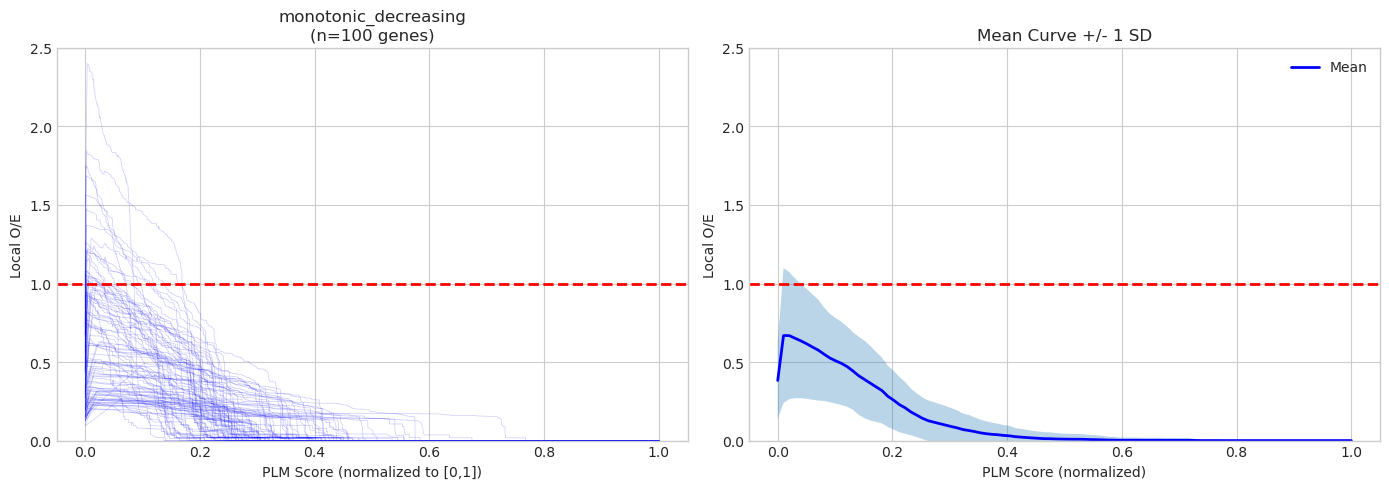

Skipping monotonic_increasing: only 0 genes


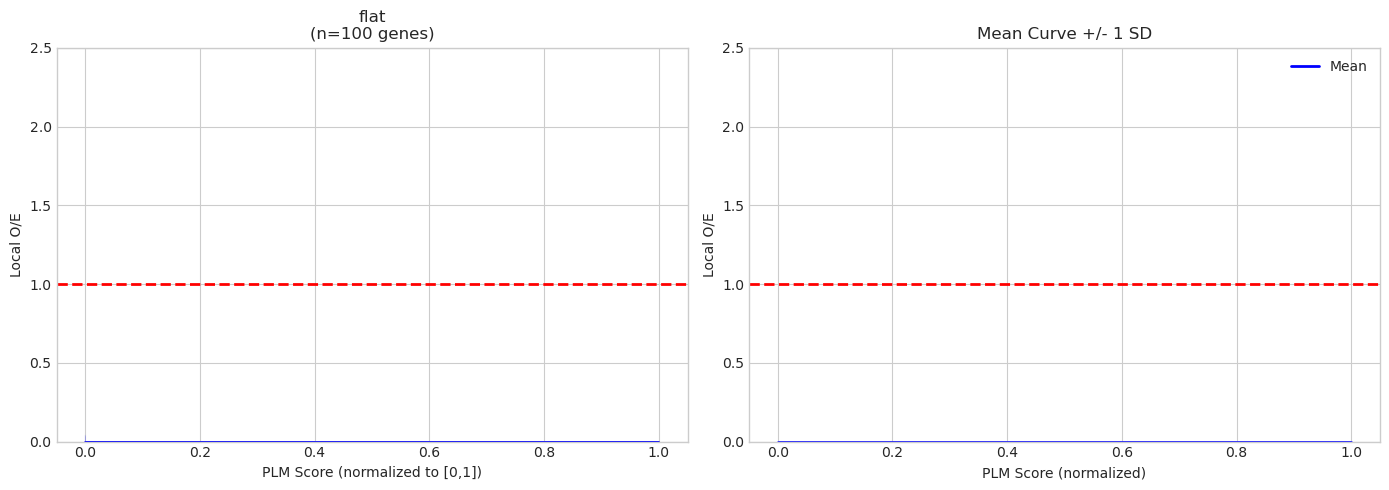

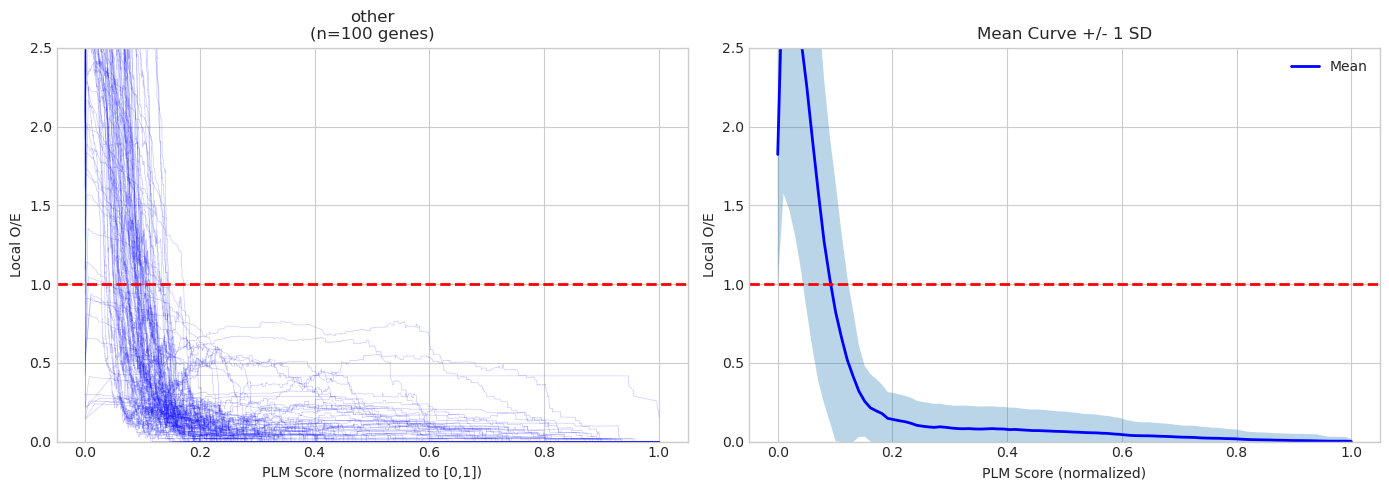

In [9]:
# Create overlay plots for each category
for category in categories_to_plot:
    cat_transcripts = stats_df.filter(pl.col('curve_category') == category)['transcript'].to_list()
    
    if len(cat_transcripts) < 5:
        print(f"Skipping {category}: only {len(cat_transcripts)} genes")
        continue
    
    fig = plot_category_overlay(category, cat_transcripts, curve_df, max_genes=100)
    plt.savefig(f'{output_dir}/overlay_{category}.png', dpi=150, bbox_inches='tight')
    plt.show()

## Step 10: ClinVar Validation

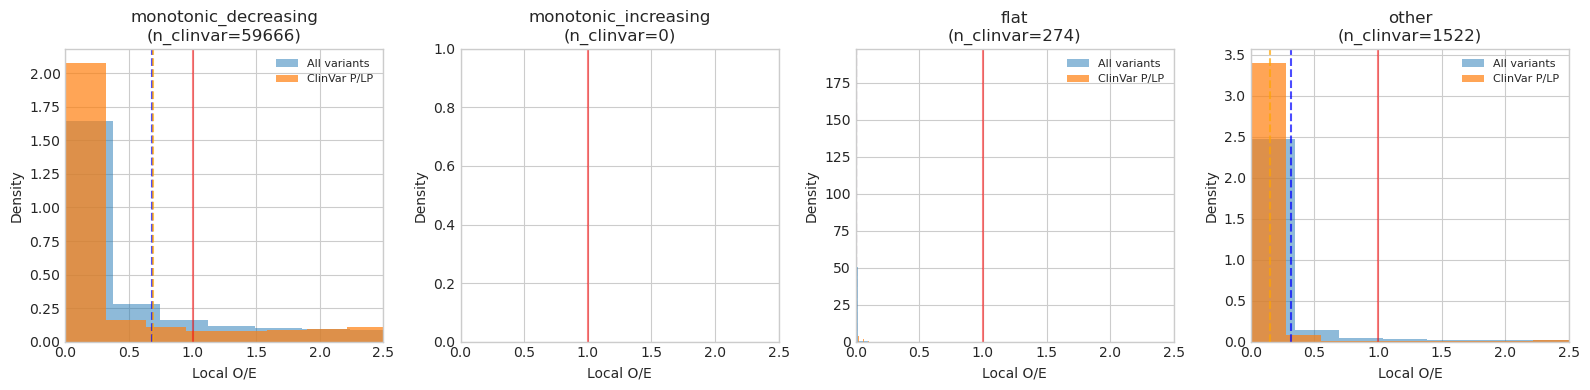


=== ClinVar O/E Summary by Category ===

monotonic_decreasing:
  All variants mean O/E: 0.678
  ClinVar P/LP mean O/E: 0.691
  ClinVar P/LP median O/E: 0.066

flat:
  All variants mean O/E: 0.001
  ClinVar P/LP mean O/E: 0.002
  ClinVar P/LP median O/E: 0.000

other:
  All variants mean O/E: 0.318
  ClinVar P/LP mean O/E: 0.152
  ClinVar P/LP median O/E: 0.000


In [10]:
# Check where ClinVar P/LP variants fall on curves
clinvar_oe_by_category = {}

for category in categories_to_plot:
    cat_transcripts = stats_df.filter(pl.col('curve_category') == category)['transcript'].to_list()
    
    # Filter curve data to this category's transcripts
    cat_curves = curve_df.filter(pl.col('transcript').is_in(cat_transcripts))
    
    # Get ClinVar O/E values
    clinvar_oes = cat_curves.filter(
        (pl.col('is_clinvar_pathogenic') == True) & 
        pl.col('local_oe').is_not_null()
    )['local_oe'].to_numpy()
    
    # Get all O/E values
    all_oes = cat_curves.filter(pl.col('local_oe').is_not_null())['local_oe'].to_numpy()
    
    clinvar_oe_by_category[category] = {
        'clinvar': clinvar_oes,
        'all': all_oes
    }

# Plot comparison
fig, axes = plt.subplots(1, len(categories_to_plot), figsize=(4*len(categories_to_plot), 4))

for i, category in enumerate(categories_to_plot):
    ax = axes[i] if len(categories_to_plot) > 1 else axes
    
    clinvar_oes = clinvar_oe_by_category[category]['clinvar']
    all_oes = clinvar_oe_by_category[category]['all']
    
    if len(clinvar_oes) > 0 and len(all_oes) > 0:
        ax.hist(all_oes, bins=30, alpha=0.5, label='All variants', density=True)
        ax.hist(clinvar_oes, bins=30, alpha=0.7, label='ClinVar P/LP', density=True)
        
        ax.axvline(x=np.mean(all_oes), color='blue', linestyle='--', alpha=0.7)
        ax.axvline(x=np.mean(clinvar_oes), color='orange', linestyle='--', alpha=0.7)
    
    ax.axvline(x=1.0, color='red', linestyle='-', alpha=0.5)
    ax.set_xlabel('Local O/E')
    ax.set_ylabel('Density')
    ax.set_title(f'{category}\n(n_clinvar={len(clinvar_oes)})')
    ax.legend(fontsize=8)
    ax.set_xlim(0, 2.5)

plt.tight_layout()
plt.savefig(f'{output_dir}/clinvar_validation.png', dpi=150, bbox_inches='tight')
plt.show()

# Print summary
print("\n=== ClinVar O/E Summary by Category ===")
for category in categories_to_plot:
    clinvar_oes = clinvar_oe_by_category[category]['clinvar']
    all_oes = clinvar_oe_by_category[category]['all']
    
    if len(clinvar_oes) > 0:
        print(f"\n{category}:")
        print(f"  All variants mean O/E: {np.mean(all_oes):.3f}")
        print(f"  ClinVar P/LP mean O/E: {np.mean(clinvar_oes):.3f}")
        print(f"  ClinVar P/LP median O/E: {np.median(clinvar_oes):.3f}")

## Step 11: Constraint Quintile Analysis

In [11]:
# Analyze curve shapes by constraint quintile
quintile_category = pd.crosstab(stats_pd['constraint_quintile'], stats_pd['curve_category'], normalize='index') * 100

print("\n=== Curve Category Distribution by Constraint Quintile ===")
print("(Q1 = most constrained, Q5 = least constrained)")
print(quintile_category.round(1))


=== Curve Category Distribution by Constraint Quintile ===
(Q1 = most constrained, Q5 = least constrained)
curve_category       flat  monotonic_decreasing  other
constraint_quintile                                   
1                    17.3                  80.0    2.7
2                     0.0                  99.7    0.3
3                     0.0                  99.7    0.3
4                     0.0                  99.9    0.1
5                     0.0                 100.0    0.0


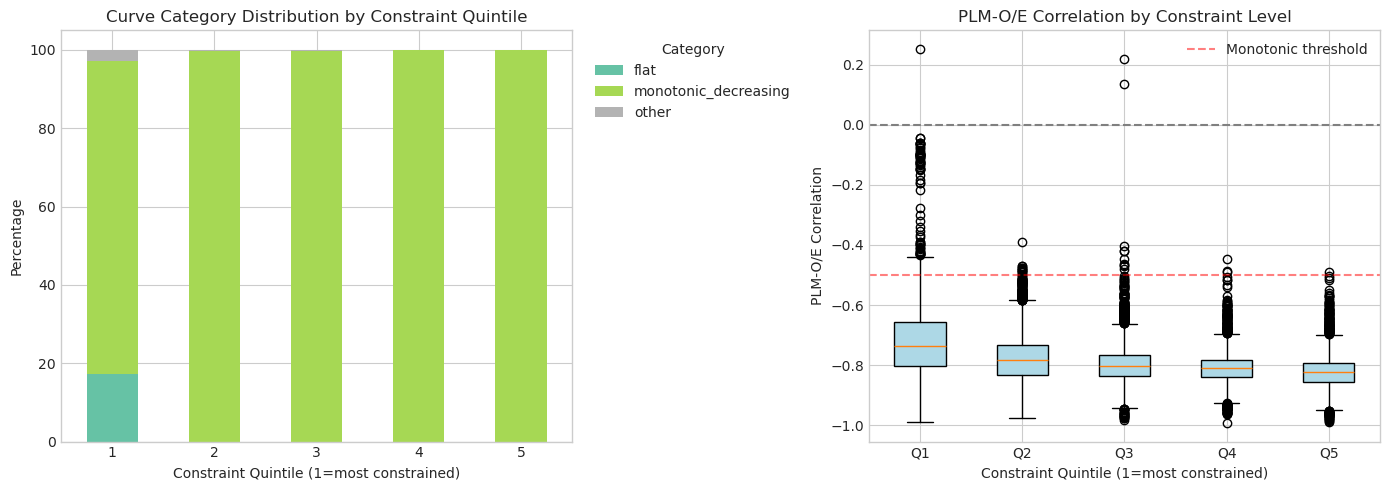

In [12]:
# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Stacked bar chart of categories by quintile
quintile_category.plot(kind='bar', stacked=True, ax=axes[0], colormap='Set2')
axes[0].set_xlabel('Constraint Quintile (1=most constrained)')
axes[0].set_ylabel('Percentage')
axes[0].set_title('Curve Category Distribution by Constraint Quintile')
axes[0].legend(title='Category', bbox_to_anchor=(1.02, 1))
axes[0].tick_params(axis='x', rotation=0)

# Correlation by quintile
box_data = [stats_pd[stats_pd['constraint_quintile'] == q]['plm_oe_corr'].dropna() for q in range(1, 6)]
bp = axes[1].boxplot(box_data, labels=['Q1', 'Q2', 'Q3', 'Q4', 'Q5'], patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('lightblue')
axes[1].axhline(y=0, color='gray', linestyle='--')
axes[1].axhline(y=-0.5, color='red', linestyle='--', alpha=0.5, label='Monotonic threshold')
axes[1].set_xlabel('Constraint Quintile (1=most constrained)')
axes[1].set_ylabel('PLM-O/E Correlation')
axes[1].set_title('PLM-O/E Correlation by Constraint Level')
axes[1].legend()

plt.tight_layout()
plt.savefig(f'{output_dir}/constraint_quintile_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

## Step 12: Save Summary Statistics

In [15]:
MAX_WINDOW = 150  # Neighbors on each side (total max = 300)
MIN_EXPECTED = 10.0  # Minimum expected count for window

# Save full statistics table (already saved in gene_stats.tsv)
print(f"Gene stats saved to {output_dir}/gene_stats.tsv")

# Print final summary
print("\n" + "="*60)
print("SUMMARY: PLM Score vs O/E Curve Analysis")
print("="*60)

print(f"\nTotal genes analyzed: {stats_df.height:,}")
print(f"Total variants: {curve_df.height:,}")
print(f"Window size: MAX_WINDOW = {MAX_WINDOW} on each side (up to 300 total)")
print(f"Minimum expected threshold: {MIN_EXPECTED}")

print("\n--- Curve Categories ---")
for cat in categories_to_plot:
    count = stats_df.filter(pl.col('curve_category') == cat).height
    pct = 100 * count / stats_df.height
    print(f"  {cat}: {count:,} ({pct:.1f}%)")

print("\n--- Key Findings ---")
mono_frac = stats_df.filter(pl.col('is_monotonic') == True).height / stats_df.height * 100
print(f"  Genes with monotonic decreasing PLM->O/E: {mono_frac:.1f}%")

flat_frac = stats_df.filter(pl.col('is_flat') == True).height / stats_df.height * 100
print(f"  Genes with flat curves (O/E range < 0.2): {flat_frac:.1f}%")

mean_corr = stats_pd['plm_oe_corr'].mean()
print(f"\n  Mean PLM-O/E correlation: {mean_corr:.3f}")
print(f"  (Negative = higher PLM score -> lower O/E, as expected)")

Gene stats saved to /storage/zoghbi/home/u235147/merged_vars/eda_plm_oe/gene_stats.tsv

SUMMARY: PLM Score vs O/E Curve Analysis

Total genes analyzed: 19,133
Total variants: 72,174,760
Window size: MAX_WINDOW = 150 on each side (up to 300 total)
Minimum expected threshold: 10.0

--- Curve Categories ---
  monotonic_decreasing: 18,341 (95.9%)
  monotonic_increasing: 0 (0.0%)
  flat: 662 (3.5%)
  other: 130 (0.7%)

--- Key Findings ---
  Genes with monotonic decreasing PLM->O/E: 96.2%
  Genes with flat curves (O/E range < 0.2): 3.5%

  Mean PLM-O/E correlation: -0.786
  (Negative = higher PLM score -> lower O/E, as expected)


In [16]:
# Save individual gene plots for top genes by variant count
from tqdm import tqdm

N_GENES_TO_PLOT = 100

top_genes = stats_df.sort('n_variants', descending=True).head(N_GENES_TO_PLOT)['transcript'].to_list()

print(f"Saving individual plots for top {N_GENES_TO_PLOT} genes by variant count...")
for transcript in tqdm(top_genes):
    gene_data = curve_df.filter(pl.col('transcript') == transcript)
    if gene_data.height < 10:
        continue
    
    gene_stats_row = stats_lookup.get(transcript, {})
    category = gene_stats_row.get('curve_category', 'unknown')
    gene_oe = gene_stats_row.get('gene_oe', np.nan)
    
    fig, ax = plt.subplots(figsize=(8, 5))
    plot_gene_curve(transcript, curve_df, gene_stats_row, ax=ax)
    ax.set_title(f'{transcript} [{category}]\n(gene O/E = {gene_oe:.2f})')
    
    plt.tight_layout()
    plt.savefig(f'{output_dir}/gene_plots/{transcript}.png', dpi=100, bbox_inches='tight')
    plt.close()

print(f"Done! Plots saved to {output_dir}/gene_plots/")

Saving individual plots for top 100 genes by variant count...


100%|██████████| 100/100 [00:13<00:00,  7.24it/s]

Done! Plots saved to /storage/zoghbi/home/u235147/merged_vars/eda_plm_oe/gene_plots/


<cell_type>markdown</cell_type>## Questions Answered

1. **What fraction of genes show monotonically decreasing O/E with increasing PLM score?**
   - See `is_monotonic` percentage in summary above
   - Expected: Higher PLM score (more pathogenic) → lower O/E (more depleted)

2. **Does gene-level constraint predict curve shape?**
   - See constraint quintile analysis - monotonic curves more common in constrained genes

3. **Do ClinVar pathogenic variants consistently fall in low O/E regions?**
   - See ClinVar validation plots - P/LP variants have lower mean O/E

4. **Are there distinct curve archetypes?**
   - Yes: monotonic decreasing, monotonic increasing, flat, and other patterns

## Implementation Notes

- Used pure Hail approach with scan operations for efficiency
- MAX_WINDOW = 150 neighbors on each side (up to 300 total variants in window)
- MIN_EXPECTED = 10.0 as threshold for reliable O/E estimation
- Exported to parquet for efficient polars-based visualization